# HECTOR Subsidiary Data Science Research: Predictive Model

## Objective

The objective of this notebook is to develop a predictive model for the HECTOR subsidiary research. The model is characterized as a **supervised multivariate regression model**. 

The model will be trained using the data provided by the HECTOR project stakeholders. The data consists of 42 features, 46 million records and is time series based with an interval of 240 milliseconds.

## Research question

What are the necessary and sufficient circumstances for reducing energy consumption of the hydrogen fuel cell powered RCV?
1. Determine if weather conditions contribute to energy consumption
2. Determine if RCV usage contribute to energy consumption
3. Determine if location circumstances contribute to energy consumption
4. Determine if a combination of the above contributes to energy consumption
5. Determine the necessary and sufficient circumstances based on 1.a to 1d

## Methodology

1. Import required general libraries - ie. polars, numpy, pandas, matplotlib, seaborn, etc.
2. Load HECTOR project dataset
3. Rename columns to more descriptive names
4. Add weather data
5. Filter out irrelevant periods - ie. working days, weekends, holidays, etc.
6. Engineer various features - ie. total power draw, distance delta, weight processed, etc.
7. Aggregate data to daily level
8. Append time based features - ie. day numbers, week numbers, yearly season, etc.
9. Drop irrelevant features - ie. datetime, etc.
10. Visualize data to understand trends and patterns
11. Train multiple models - ie. SVM, Random Forest, XGBoost, etc.
12. Evaluate models using cross-validation
13. Select best model based on evaluation results


## 1. Import required libraries

Import all required libraries for the project. The listed packages are the usual suspects for data analysis, visualization, and machine learning.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

# Local imports
from data import column_names

## 2. Load HECTOR project dataset

Load the HECTOR project dataset into a lazyframe. The dataset is in parquet format and will be loaded using the Polars library. We are using Polars instead of Pandas because of the size of the dataset. Polars is a Rust-based library that is designed to handle large datasets.

In [2]:
from data import load_dataset

lf = pl.scan_parquet(load_dataset().filepath)

2024-03-25 15:29:32.825 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/koendirkvanesterik/.cache/mads_datasets/garbage
2024-03-25 15:29:32.825 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/koendirkvanesterik/.cache/mads_datasets/garbage/garbage.parq


## 3. Preprocess dataset

The dataset supplied by our stakeholders has column names that are not very descriptive. We will rename the columns to more descriptive names to make the dataset more understandable.

In [3]:
from data import rename_columns

lf = rename_columns(lf)

# lf.collect().to_pandas().info()

We also need to sort the dataset by the datetime column to ensure that the data is in the correct order.

In [4]:
lf = lf.sort(column_names.DATETIME)

## 4. Add weather data

We will add air temperature to the HECTOR project dataset. This will be used to determine if weather conditions contribute to energy consumption. The data is sourced from the German Weather Service (DWD) made available via https://wetterdienst.readthedocs.io/en/latest/index.html.

In [5]:
from data import add_air_temperature

lf = add_air_temperature(lf)

# sns.histplot(data=lf.select("air_temperature").collect())

## 5. Filter out irrelevant periods

We will filter out irrelevant periods from the dataset:

- weekends
- holidays
- non-working hours

This because we are only interested in periods where the RCV is in operation.

In [6]:
# from data import filter_working_days

# lf = filter_working_days(lf)

We might even want to filter only on data where there is GPS data available.

In [7]:
# lf = lf.filter(pl.col(columns.GPS_ALTITUDE).is_not_null())

# lf.select(columns.DATETIME).collect()

Or we just drop all rows with missing values.

In [8]:
lf = lf.drop_nulls()

## 6. Engineer various features

In order to assess the energy consumption of the RCV, we will engineer various features as mentioned in the research question. These features will be used to train the predictive model:

- Vehicle Distance Delta
- Road Slope
- Weight Processed
- Total Power Use

In [9]:
lf = (
    lf
    # Engineer feature: Vehicle Distance Delta
    .with_columns(
        pl.col(column_names.VEHICLE_DISTANCE)
        .diff()
        .alias(column_names.VEHICLE_DISTANCE_DELTA)
    )
    # Engineer feature: Road Slope
    .with_columns(
        # Calculate the angle in radians
        pl.arctan2d(
            pl.col(column_names.GPS_ALTITUDE).diff(),
            pl.col(column_names.VEHICLE_DISTANCE_DELTA),
        ).alias(column_names.ROAD_SLOPE)
    )
    # Engineer feature: Weight Processed
    # .with_columns(
    #     (pl.col(columns.VEHICLE_DISTANCE_DELTA) * pl.lit(0.5)).alias(columns.WEIGHT_PROCESSED)
    # )
    # Engineer feature: Motor Power Use
    .with_columns(
        (
            pl.col(
                column_names.POWER_VOLTAGE_BATTERY_DIRECT_CURRENT,
            )
            * pl.col(column_names.MOTOR_CURRENT)
        ).alias(column_names.MOTOR_POWER_USE)
    )
    # Engineer feature: Total Power Use
    # - Compactor power use is divided by 10 as described by stakeholder documentation
    # - HVAC power use could be included ... worth investigating
    .with_columns(
        (
            (pl.col(column_names.COMPACTOR_POWER_USE) / 10)
            + pl.col(column_names.MOTOR_POWER_USE)
        ).alias(column_names.TOTAL_POWER_USE)
    )
)

# lf.select(
#     column_names.DATETIME,
#     column_names.VEHICLE_DISTANCE_DELTA,
#     column_names.ROAD_SLOPE,
#     column_names.TOTAL_POWER_USE,
# ).collect().describe()

In order to get more sense of the routes taken by the RCV, we will also apply a clustering algorithm to the GPS data.

In [10]:
# sns.scatterplot(lf.select(
#     column_names.GPS_LONGITUDE,
#     column_names.GPS_LATITUDE,
# ).collect().to_pandas(), x=column_names.GPS_LONGITUDE, y=column_names.GPS_LATITUDE)

## 7. Aggregate data to daily level

We need to aggregate the data to a daily level. This in order to be able to train the model on a daily basis. For almost all features we will calculate the mean. The features that are exceptions are:

- Datetime
- Vehicle Distance Delta

In [11]:
lf = (
    lf.sort(column_names.DATETIME)
    .group_by_dynamic(column_names.DATETIME, every="1d")
    .agg(
        pl.all()
        .exclude(column_names.DATETIME, column_names.VEHICLE_DISTANCE_DELTA)
        .mean(),
        pl.col(column_names.VEHICLE_DISTANCE_DELTA).sum(),
    )
)

## 8. Append time based features

## 9. Drop irrelevant features

We need to drop irrelevant features from the dataset. This due to to the covariance of the engineered features. When these are maintained in the dataset, the model will be biased towards these features and weigh them more heavily than the other features. This will result in a model that is not generalizable to other datasets.

The features that need to be maintained and not be dropped are:

- Air Temperature
- Road Slope
- Total Power Use (target variable)
- Vehicle Distance Delta
- Weight Processed

In [12]:
lf = lf.select(
    column_names.AIR_TEMPERATURE,
    column_names.ROAD_SLOPE,
    column_names.THROTTLE_PEDAL,
    column_names.TOTAL_POWER_USE,
    column_names.VEHICLE_DISTANCE_DELTA,
)

df = lf.collect().to_pandas()

df.describe()

Air Temperature  Road Slope  Throttle Pedal  Total Power Use  \
count       132.000000  132.000000      132.000000       132.000000   
mean         11.063833    1.730334      209.080483    256422.177497   
std           7.073885   11.153892       94.732741    153013.173020   
min          -3.775180  -27.529619        0.000000         0.000000   
25%           6.547076   -0.624949      202.307805    156438.080110   
50%          10.298586    0.094670      236.301351    280379.820236   
75%          15.680030    0.953531      260.217921    361229.523245   
max          26.287715   74.467418      403.220300    698412.500000   

       Vehicle Distance Delta  
count            1.320000e+02  
mean             7.015148e+04  
std              5.786247e+06  
min             -2.812976e+07  
25%              2.555625e+04  
50%              8.783500e+04  
75%              9.489875e+04  
max              2.828068e+07

## Visualize data to understand trends and patterns

We will visualize the data to understand trends and patterns. This will help us to understand the relationships between the features and the target variable.

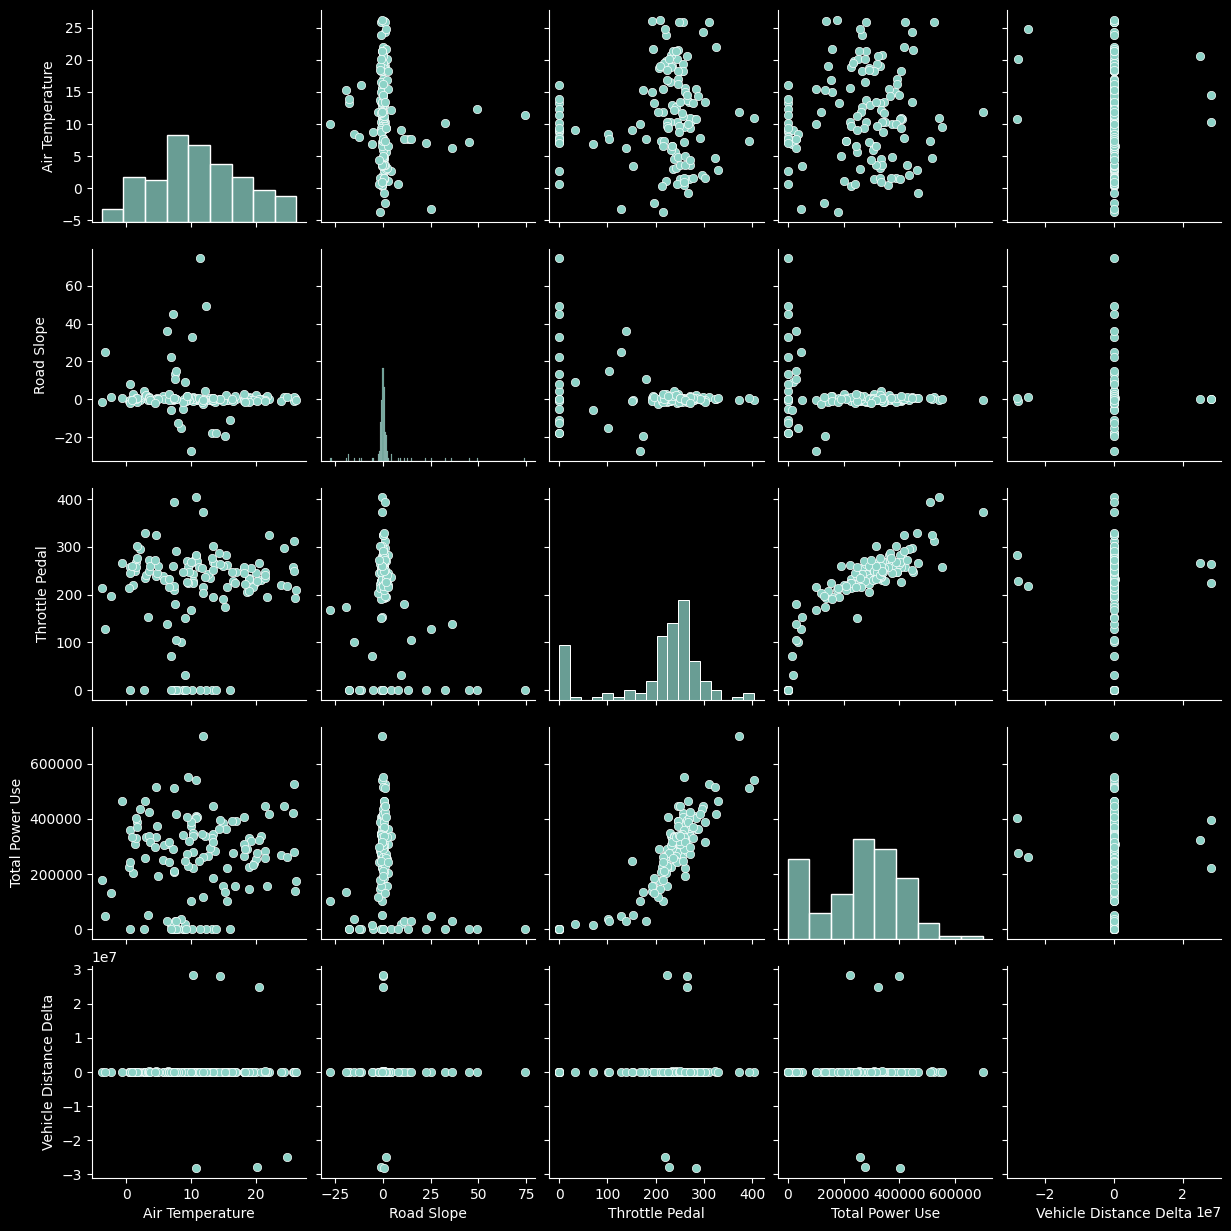

In [13]:
sns.pairplot(df)

## Train multiple models

We will train multiple models on the dataset. The models that we will train are:

- Linear Regression
- Support Vector Machine
- Random Forest
- XGBoost

### Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


rcv = df.drop(column_names.TOTAL_POWER_USE, axis=1)
rcv_labels = df[column_names.TOTAL_POWER_USE].copy()

# Why do I use a standard scaler here?
# - The data contains a lot of noise
# - Research this question
lin_reg = make_pipeline(StandardScaler(), LinearRegression())
lin_reg.fit(rcv, rcv_labels)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [15]:
rcv_predictions = lin_reg.predict(rcv)

pd.DataFrame(
    {
        "Predictions": rcv_predictions[:5].round(-2),
        "Labels": rcv_labels[:5].values,
    }
)

Predictions         Labels
0     274700.0  238798.461451
1     311400.0  447472.036943
2     327700.0  420103.442731
3     235000.0  137930.076221
4     311200.0  390873.292455

In [16]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(rcv_labels, rcv_predictions)

69280.30936130865

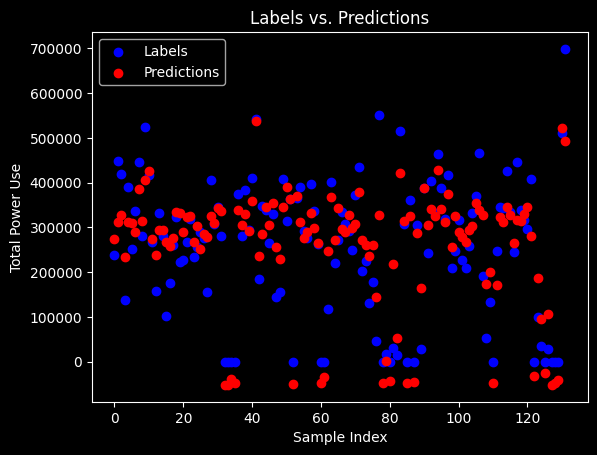

In [17]:
plt.scatter(range(len(rcv_labels)), rcv_labels, color='blue', label='Labels')
plt.scatter(range(len(rcv_predictions)), rcv_predictions, color='red', label='Predictions')
plt.legend()
plt.title('Labels vs. Predictions')
plt.xlabel('Sample Index')
plt.ylabel(column_names.TOTAL_POWER_USE)
plt.show()